In [1]:
# Import modules
import sys
sys.path.append(r"c:/Users/Raees/Desktop/stuff/NuOscProbExact/src")

from oscprob2nu import *
from globaldefs import *
from hamiltonians2nu import *
from hamiltonians3nu import *
from oscprob3nu import *

import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.integrate import simpson, quad
from scipy.interpolate import interp1d
import copy as cp
import builtins
import itertools
import scipy.linalg as la
from scipy.linalg import expm
import cmath
import sympy as sp

In [2]:
# Gaussian fit
def gaus(data, amplitude, mean, sigma):
    return amplitude * math.e**((-0.5 * (data - mean)**2) / sigma**2)

def fluctuated_fit(gaus, bin_centers, counts):
    popt, _ = curve_fit(gaus, bin_centers, counts)
    return popt

def param_values2(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.41e-3, 0.07e-3),  # ± 0.07e-3
        's2th23': (0.57, 0.03, 0.04),  # +0.03, -0.04
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central
param_values2('Dm2_32', 0.5)

0.0024449999999999997

In [3]:
# Parameters
bin_centers = np.array([0.375, 0.875, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.125, 2.375, 2.6375, 2.8875, 3.25, 3.75, 4.5])
bin_edges = np.array([0, 0.75, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.775, 3, 3.5, 4, 5])

# Event counts for muon neutrino beam, muon-to-muon
counts_nd = np.array([5, 42, 72, 96, 120, 148, 170, 192, 208, 214, 212, 204, 170, 112, 66, 36, 16, 5, 1])
counts_fd = np.array([0, 3, 1, 3, 1, 2, 2, 4, 6, 9, 15, 12, 15.8, 10, 7, 9, 3.2, 2.8, 1.8])
adjusted_counts_fd = np.array([ 0.  ,  7.5 ,  1.  ,  3.  ,  1.  ,  2.  ,  2.  ,  4.  ,  6.  ,
        9.  , 15.  , 12.  , 39.5 , 25.  , 19.25, 20.25, 16.  , 14.  ,
       18.  ])
adjusted_counts_nd = np.array([ 37500., 105000.,  72000.,  96000., 120000., 148000., 170000.,
       192000., 208000., 214000., 212000., 204000., 425000., 280000.,
       181500.,  81000.,  80000.,  25000.,  10000.])

# Event counts for electron neutrio beam, muon-to-electron
counts_nd_e = np.array([0.01, 0.5, 2.4, 4.6, 4, 2.6, 1.8 ,1.4, 1.2])
adjusted_counts_nd_e = np.array([10, 500, 2400, 4600, 400, 2600, 1800, 1400, 1200])
counts_fd_e = np.array([5 ,21, 18, 4, 1, 1])
bin_centers_e = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])
bin_edges_e = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

length_nd = 1 # [km]
length_fd = 810 # [km]

bin_widths = bin_edges[1:] - bin_edges[:-1]

# Event counts for antineutrino beam
anti_counts_nd = np.array([2.5, 20, 38.75, 45 ,67.5, 70, 85, 97.5, 107.5, 113.75, 115, 111.25, 95, 62.5, 37.5, 20, 10, 2.5, 0])
anti_counts_fd = np.array([0.25, 2, 1, 2, 0, 2, 3, 0, 0, 8, 3, 7, 4.4, 6, 2.4, 2, 2.4, 1.25, 1.75])
anti_counts_nd_e = np.array([0, 0.25, 1.3, 2.5, 2.52, 1.9, 1.35, 1.15, 0.95]) # The High CNN one, cause it might be better?
anti_counts_fd_e = np.array([1, 8, 5, 3, 1, 1])

adjusted_anti_counts_nd_e = np.array([0, 250, 1300, 2500, 2520, 1900, 1350, 1150, 950])
adjusted_anti_counts_nd = anti_counts_nd * (bin_widths / 0.1) * 1000
adjusted_anti_counts_fd = anti_counts_fd * (bin_widths / 0.1)

print(adjusted_anti_counts_fd)

print('sum of nd events', np.sum(adjusted_counts_nd))
print('Sum of fd events',np.sum(adjusted_counts_fd))
print('Ratio fd/nd events',np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd))

print('sum of nd e events', np.sum(adjusted_counts_nd_e))
print('sum of fd e events', np.sum(counts_fd_e))
print('Ratio fd/nd e events',np.sum(counts_fd_e) / np.sum(adjusted_counts_nd_e))


print('sum of nd data points',np.sum(counts_nd))

[ 1.875  5.     1.     2.     0.     2.     3.     0.     0.     8.
  3.     7.    11.    15.     6.6    4.5   12.     6.25  17.5  ]
sum of nd events 2861000.0
Sum of fd events 214.5
Ratio fd/nd events 7.497378538972387e-05
sum of nd e events 14910
sum of fd e events 50
Ratio fd/nd e events 0.00335345405767941
sum of nd data points 2089


Fitted parameters for observed the unoscillated ND events: Amplitude = 212.76692701207105, Mean = 1.8044188236034169, Sigma = 0.525448417032163
Fitted parameters for observed the unoscillated ND electon events: Amplitude = 4.218662147714044, Mean = 2.1341687610051183, Sigma = 0.8475810459857663
Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = 113.1060196955553, Mean = 1.8355298839724858, Sigma = 0.5285564990530245
Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = 2.4344413635605364, Mean = 2.356842604598921, Sigma = 0.9997075655274238


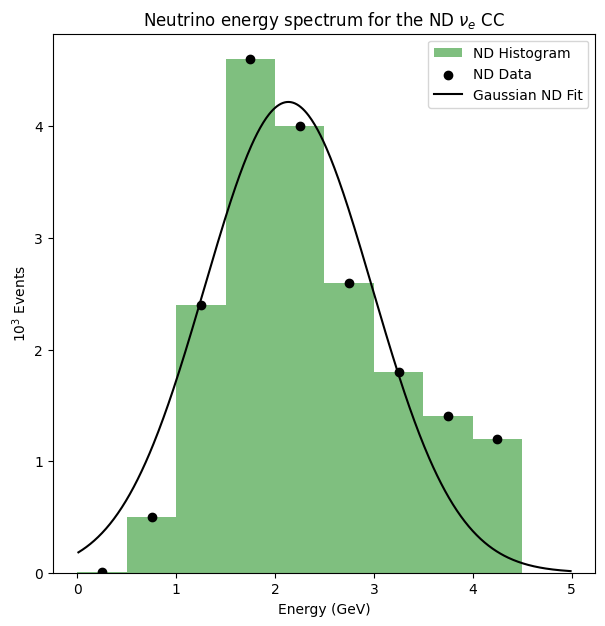

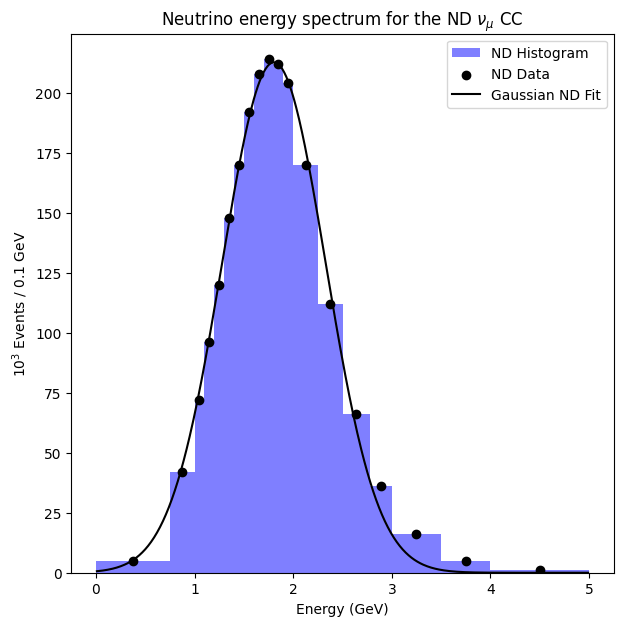

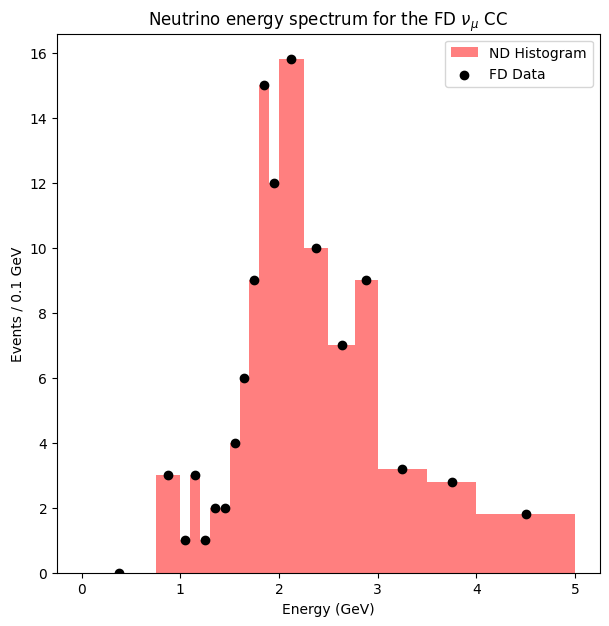

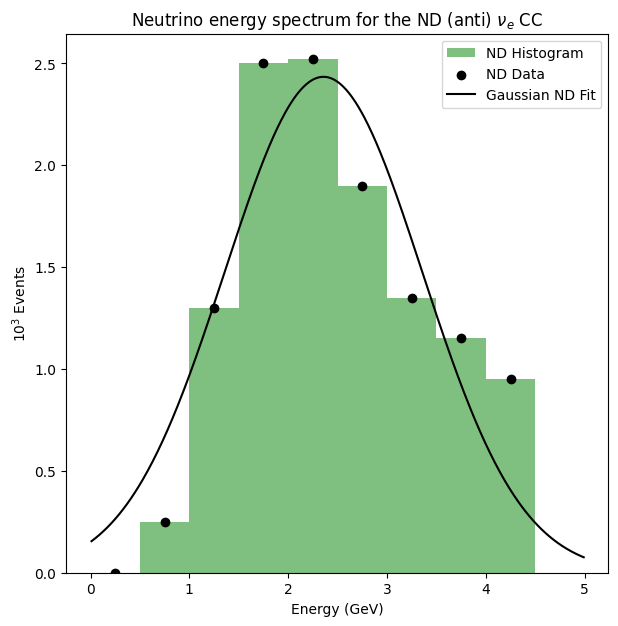

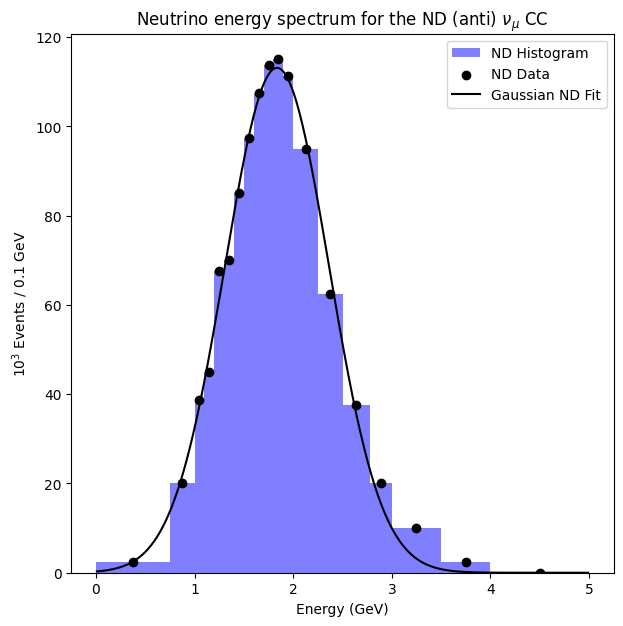

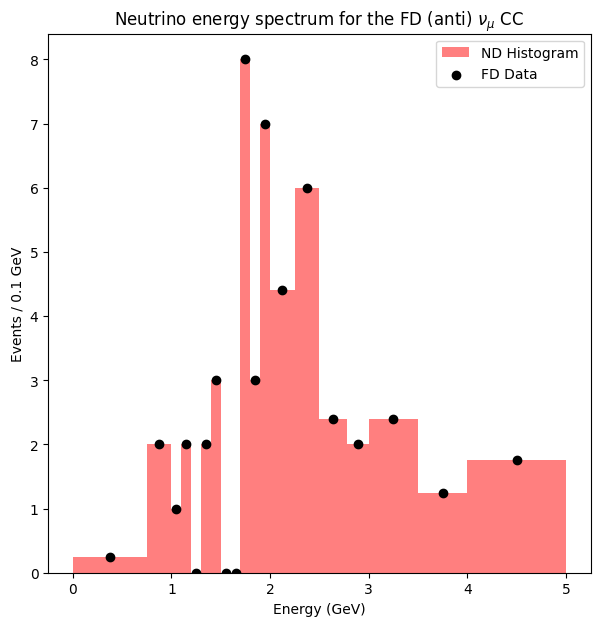

In [4]:
# Finding the Gaussian fit for the observed energy spectrum

initial_guess = [140, 2, 0.5]

popt_nd, _ = curve_fit(gaus, bin_centers, counts_nd, p0=initial_guess)
print(f"Fitted parameters for observed the unoscillated ND events: Amplitude = {popt_nd[0]}, Mean = {popt_nd[1]}, Sigma = {popt_nd[2]}")


popt_nd_e, _ = curve_fit(gaus, bin_centers_e, counts_nd_e, p0=[5,2, 0.5])
print(f"Fitted parameters for observed the unoscillated ND electon events: Amplitude = {popt_nd_e[0]}, Mean = {popt_nd_e[1]}, Sigma = {popt_nd_e[2]}")

popt_anti_nd, _ = curve_fit(gaus, bin_centers, anti_counts_nd, p0=[120,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = {popt_anti_nd[0]}, Mean = {popt_anti_nd[1]}, Sigma = {popt_anti_nd[2]}")


popt_anti_nd_e, _ = curve_fit(gaus, bin_centers_e, anti_counts_nd_e, p0=[5,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = {popt_anti_nd_e[0]}, Mean = {popt_anti_nd_e[1]}, Sigma = {popt_anti_nd_e[2]}")

x = np.arange(0.01,5,0.01)


plt.figure(figsize=(7,7))
plt.hist(bin_edges_e[:-1],bin_edges_e ,weights=counts_nd_e, density=False, alpha=0.5, color='g', label='ND Histogram')
plt.scatter(bin_centers_e, counts_nd_e, color='black', label='ND Data')
plt.plot(x, gaus(x,*popt_nd_e), color='black', label='Gaussian ND Fit')
plt.title(r'Neutrino energy spectrum for the ND $\nu _e$ CC')
plt.ylabel('$10^3$ Events')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.hist(bin_edges[:-1],bin_edges ,weights=counts_nd, density=False, alpha=0.5, color='b', label='ND Histogram')
plt.scatter(bin_centers, counts_nd, color='black', label='ND Data')
plt.plot(x, gaus(x,*popt_nd), color='black', label='Gaussian ND Fit')
plt.title(r'Neutrino energy spectrum for the ND $\nu _\mu$ CC')
plt.ylabel('$10^3$ Events / 0.1 GeV')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.hist(bin_edges[:-1], bin_edges,weights=counts_fd, density=False, alpha=0.5, color='r', label='ND Histogram')
plt.scatter(bin_centers, counts_fd, color='black', label='FD Data')
plt.title(r'Neutrino energy spectrum for the FD $\nu _\mu$ CC')
plt.ylabel('Events / 0.1 GeV')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.hist(bin_edges_e[:-1],bin_edges_e ,weights=anti_counts_nd_e, density=False, alpha=0.5, color='g', label='ND Histogram')
plt.scatter(bin_centers_e, anti_counts_nd_e, color='black', label='ND Data')
plt.plot(x, gaus(x,*popt_anti_nd_e), color='black', label='Gaussian ND Fit')
plt.title(r'Neutrino energy spectrum for the ND (anti) $\nu _e$ CC')
plt.ylabel('$10^3$ Events')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.hist(bin_edges[:-1],bin_edges ,weights=anti_counts_nd, density=False, alpha=0.5, color='b', label='ND Histogram')
plt.scatter(bin_centers, anti_counts_nd, color='black', label='ND Data')
plt.plot(x, gaus(x,*popt_anti_nd), color='black', label='Gaussian ND Fit')
plt.title(r'Neutrino energy spectrum for the ND (anti) $\nu _\mu$ CC')
plt.ylabel('$10^3$ Events / 0.1 GeV')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

plt.figure(figsize=(7,7))
plt.hist(bin_edges[:-1], bin_edges,weights=anti_counts_fd, density=False, alpha=0.5, color='r', label='ND Histogram')
plt.scatter(bin_centers, anti_counts_fd, color='black', label='FD Data')
plt.title(r'Neutrino energy spectrum for the FD (anti) $\nu _\mu$ CC')
plt.ylabel('Events / 0.1 GeV')
plt.xlabel('Energy (GeV)')
plt.legend()
plt.show()

In [5]:
def osc_prob_2nu(type, sector, case, length, transition):
    """
    Returns oscillated fit, event counts, Poisson fluctuated counts and probabilities

    Args:
        type (str): 'neutrino' or 'antineutrino'
        sector (str): '12' or '23'
        case (str): 'vacuum' or 'matter'
        length (int): detector distance
        transition: (str): 'mm' muon-to-muon, 'me' muon-to-electron, etc
    """
    energy = x*1e9
    length_scaled = length * CONV_KM_TO_INV_EV

    if sector == '12':
        mixing_angle = math.sqrt(0.307)
        delta_mass_squared = 7.53e-5
        transition_map = {'me': 2, 'mm': 3}
    elif sector == '23':
        mixing_angle = math.sqrt(0.57)
        delta_mass_squared = 2.41e-3
        transition_map = {'mm': 0, 'mt': 1}
    else:
        raise ValueError(f"Invalid sector '{sector}'. Must be '12' or '23'.")
    
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition '{transition}'. Must match the sector.")
    
    if type == 'neutrino':
        popt = popt_nd
        bin_edge = bin_edges
    elif type == 'antineutrino':
        popt = popt_anti_nd
        bin_edge = bin_edges
    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")

    # Calculate energy-independent vacuum Hamiltonian
    if type == 'neutrino':
        h_vacuum_energy_indep = hamiltonian_2nu_vacuum_energy_independent(mixing_angle, delta_mass_squared)
    else:
        h_vacuum_energy_indep = hamiltonian_2nu_vacuum_energy_independent(mixing_angle, delta_mass_squared)
        h_vacuum_energy_indep = np.conj(h_vacuum_energy_indep)

    # Define a function for Hamiltonian calculation
    if case == 'vacuum':
        def calculate_hamiltonian(e): 
            return h_vacuum_energy_indep / e
    elif case == 'matter' and type == 'neutrino':
        def calculate_hamiltonian(e): return hamiltonian_2nu_matter(h_vacuum_energy_indep, e, VCC_EARTH_CRUST)
    elif case == 'matter' and type == 'antineutrino':
        def calculate_hamiltonian(e): return hamiltonian_2nu_matter(h_vacuum_energy_indep, e, -VCC_EARTH_CRUST)
    else:
        raise ValueError(f"Invalid case '{case}'. Must be 'vacuum' or 'matter'.")
    
    # Compute probabilities
    probabilities = [
        probabilities_2nu(calculate_hamiltonian(e), length_scaled)[index]
        for e in energy
    ]

    gaus_fit = probabilities * gaus(x, *popt)
    gaussian_func = interp1d(x, gaus_fit, fill_value=0, bounds_error=False)
    print('Total number of events (without scaling) = ', np.sum(gaus_fit))

    # Getting the counts
    areas = []
    for i in range(len(bin_edge) - 1):
        a, b = bin_edge[i], bin_edge[i + 1]
        area, _ = quad(gaussian_func, a, b)
        areas.append(area)

    bin_widths = np.diff(bin_edge)
    print('Areas = ', areas)
    areas = np.array(areas)
    print('Sum of areas = ', np.sum(areas))

    scaling_factors = {
        ('antineutrino', None): (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * (14981.358271525794 / 2954.5295146861217)),
        ('neutrino', None): (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * 28014.98644788842 / 5558.977756872476),
        }
    
    if length == length_fd:
        factor = scaling_factors.get((type, index), scaling_factors.get((type, None), 1))
        counts = (areas / bin_widths) * factor

    elif length == length_nd:
        counts = areas / bin_widths

    print('Counts = ', counts)
    print('Total Counts = ', np.sum(counts))
    fluc_counts = np.random.poisson(counts)

    return gaus_fit, counts, fluc_counts, np.array(probabilities)
 
        

In [6]:
def osc_prob_3nu(type, case, length, transition, fractions):
    """
    Returns counts, error bars, poisson fluctuated counts, probabilities

    Args:
        type (str): 'neutrino' or 'antineutrino'
        case (str): 'vacuum' or 'matter'
        length (int): detector distance
        transition: (str): 'Pmm' muon-to-muon, 'Pme' muon-to-electron, etc
        fractions (float): Fraction of the uncertainty (-1 to 1 for ±1σ)
    """
    # Constants
    energy = x * 1e9
    length_scaled = length * CONV_KM_TO_INV_EV
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV
    
    # Mapping of transitoin types of indices
    transition_map = {'Pee': 0, 'Pem': 1, 'Pet': 2, 'Pme': 3, 'Pmm': 4, 
                      'Pmt': 5, 'Pte': 6, 'Ptm': 7, 'Ptt': 8}
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition: {transition}")
    
    # Fixed and varying parameters for calculations
    fixed_params = ['s2th12', 'Dm2_21']
    varying_params = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']
    fixed_param_values = {param: param_values2(param, 0) for param in fixed_params} # Fixed parameter values obtained from a function
    fraction_combiantion = list(itertools.product(fractions, repeat=len(varying_params))) # Generating combinations of fractions for varying parameters
    
    # Getting params based on type
    if type == 'neutrino':
        popt = popt_nd
        bin_edge = bin_edges
    elif type == 'antineutrino':
        popt = popt_anti_nd
        bin_edge = bin_edges
    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")
    
    # Dictionary to store Hamiltonians and counts
    hamiltonians = {}
    counts_dict = {}
    size_dict = {}
    iterations = 0
    
    gaus_x = gaus(x, *popt)

    # Loop through each fraction combination
    for fraction_values in fraction_combiantion:
        # Obtain parameter values for varying parameters
        param_values = {param: param_values2(param, frac) for param, frac in zip(varying_params, fraction_values)}
        iterations += 1
        full_param_values = {**fixed_param_values, **param_values}
        print(f'Iteration {iterations} with params: {param_values}')

        # Calculate Hamiltonian
        if type == 'neutrino':
            hamiltonians[fraction_values] = hamiltonian_3nu_vacuum_energy_independent(
            full_param_values['s2th12'],
            full_param_values['s2th23'],
            full_param_values['s2th13'],
            full_param_values['d_cp'],
            full_param_values['Dm2_21'],
            full_param_values['Dm2_32']
        )
        elif type == 'antineutrino':
            hamiltonians[fraction_values] = hamiltonian_3nu_vacuum_energy_independent(
            full_param_values['s2th12'],
            full_param_values['s2th23'],
            full_param_values['s2th13'],
            full_param_values['d_cp'],
            full_param_values['Dm2_21'],
            full_param_values['Dm2_32']
        )
            hamiltonians[fraction_values] = np.conj(hamiltonians[fraction_values])

        # Adjust Hamiltonian based on case
        if case == 'vacuum':
            def calculate_hamiltonian(h, e): return h / e
        elif case == 'matter' and type == 'neutrino':
            def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, VCC_EARTH_CRUST)
        elif case == 'matter' and type == 'antineutrino':
            def calculate_hamiltonian(h, e): return hamiltonian_3nu_matter(h, e, -VCC_EARTH_CRUST)
        else:
            raise ValueError('Invalid case')
        
        # Oscillation probability calculation
        probabilities = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e),
                                           length_scaled)[index] for e in energy])
        osc_prob = probabilities * gaus_x
        gaussian_func = interp1d(x, osc_prob, fill_value=0, bounds_error=False)
        print('Total number of events (without scaling) = ', np.sum(osc_prob))

        prob_mm_nd = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_nd)[4] for e in energy])
        prob_mm_fd = np.array([probabilities_3nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_fd)[4] for e in energy])

        gaus_mm_nd, gaus_mm_fd = prob_mm_nd * gaus_x, prob_mm_fd * gaus_x

        # Calculate areas under the curve for probability distribution
        areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
        bin_widths = np.diff(bin_edge)
        areas = np.array(areas)
        print('Sum of areas = ', np.sum(areas))

        # Scaling factors based on detector type and index
        scaling_factors = {
            #('antineutrino', 3): (np.sum(anti_counts_fd_e) / np.sum(adjusted_anti_counts_nd_e)) * ((np.sum(gaus_me_nd) / np.sum(gaus_me_fd))),
            ('antineutrino', None): (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * (np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))),
            #('neutrino', 3): (np.sum(counts_fd_e) / np.sum(adjusted_counts_nd_e)) * ((np.sum(gaus_me_nd) / np.sum(gaus_me_fd))),
            ('neutrino', None): (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd)),
        }

        # Determines counts
        if length == 810:
            factor = scaling_factors.get((type, index), scaling_factors.get((type, None), 1))
            counts = (areas / bin_widths) * factor

        elif length == 1:
            counts = areas / bin_widths
        else:
            raise ValueError('Invalid Length')
        
        # Store counts and their sum in dictionaries
        counts_dict[fraction_values] = counts
        size_dict[fraction_values] = np.sum(counts)
    
    # Find counts at zero fraction and corresponding highest and lowest counts
    zero_fraction = tuple(0 for _ in varying_params)
    if zero_fraction not in counts_dict:
        raise KeyError(f'Fraction {zero_fraction} not found in counts_dict. Check your input fractions.')
    count_at_zero = counts_dict[zero_fraction]
    highest_fraction = builtins.max(size_dict, key=size_dict.get)
    lowest_fraction = builtins.min(size_dict, key=size_dict.get)
    highest_count = size_dict[highest_fraction]
    lowest_count = size_dict[lowest_fraction]

    print('\n')
    print(f"Highest count: {highest_count} at fraction: {highest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, highest_fraction)]}")
    print(f"Lowest count: {lowest_count} at fraction: {lowest_fraction}")
    print(f"Corresponding parameters: {[f'{param}={param_values2(param, frac)}' for param, frac in zip(varying_params, lowest_fraction)]}")

    # Retrieve counts and errors for highest and lowest fractions
    upper_counts = counts_dict[highest_fraction]
    lower_counts = counts_dict[lowest_fraction]
    upper_error = upper_counts - count_at_zero
    lower_error = count_at_zero - lower_counts
    sys_err = np.abs([lower_error, upper_error])
    print(f'Lower error = {lower_error}, Upper_error = {upper_error}')

    # Generate Poisson fluctuated counts
    #print('Counts = ', counts)
    print('Total Counts = ', np.sum(count_at_zero))
    fluc_counts = np.random.poisson(count_at_zero)

    return np.array(count_at_zero), sys_err, fluc_counts, np.array(probabilities)

In [7]:
print('\n Model 1:')
fit1, c1, fc1, p1 = osc_prob_2nu('neutrino', '12', 'vacuum', length_nd, 'mm')
print('\n Model 2:')
fit2, c2, fc2, p2 = osc_prob_2nu('neutrino', '23', 'vacuum', length_fd, 'mm')

print('\n Model 3:')
fit3, c3, fc3, p3 = osc_prob_2nu('neutrino', '12', 'matter', length_nd, 'mm')
print('\n Model 4:')
fit4, c4, fc4, p4 = osc_prob_2nu('neutrino', '23', 'matter', length_fd, 'mm')

print('\n Model 5:')
fit1_, c1_, fc1_, p1_ = osc_prob_2nu('antineutrino', '12', 'vacuum', length_nd, 'mm')
print('\n Model 6:')
fit2_, c2_, fc2_, p2_ = osc_prob_2nu('antineutrino', '23', 'vacuum', length_fd, 'mm')

print('\n Model 7:')
fit3_, c3_, fc3_, p3_ = osc_prob_2nu('antineutrino', '12', 'matter', length_nd, 'mm')
print('\n Model 8:')
fit4_, c4_, fc4_, p4_ = osc_prob_2nu('antineutrino', '23', 'matter', length_fd, 'mm')

print('\n Model 9:')
fit5, c5, fc5, p5 = osc_prob_2nu('neutrino', '12', 'vacuum', length_nd, 'me')
print('\n Model 10:')
fit6, c6, fc6, p6 = osc_prob_2nu('neutrino', '12', 'vacuum', length_fd, 'me')

print('\n Model 11:')
fit7, c7, fc7, p7 = osc_prob_2nu('neutrino', '12', 'matter', length_nd, 'me')
print('\n Model 12:')
fit8, c8, fc8, p8 = osc_prob_2nu('neutrino', '12', 'matter', length_fd, 'me')

print('\n Model 13:')
fit5_, c5_, fc5_, p5_ = osc_prob_2nu('antineutrino', '12', 'vacuum', length_nd, 'me')
print('\n Model 14:')
fit6_, c6_, fc6_, p6_ = osc_prob_2nu('antineutrino', '12', 'vacuum', length_fd, 'me')

print('\n Model 15:')
fit7_, c7_, fc7_, p7_ = osc_prob_2nu('antineutrino', '12', 'matter', length_nd, 'me')
print('\n Model 16:')
fit8_, c8_, fc8_, p8_ = osc_prob_2nu('antineutrino', '12', 'matter', length_fd, 'me')






 Model 1:
Total number of events (without scaling) =  28014.986436829386
Areas =  [6.186176573793727, 11.35140377930323, 7.602939463607213, 9.804944194235437, 12.196271918825635, 14.632802381564526, 16.93348622895338, 18.900955709521604, 20.348840439445745, 21.130709272348437, 21.164451193256046, 20.44647644714301, 43.897298239354434, 29.545828517892794, 16.933791668620792, 5.863227353071288, 3.0317480140771322, 0.17127464154841168, 0.004113860709023662]
Sum of areas =  280.14673989727186
Counts =  [8.24823543e+00 4.54056151e+01 7.60293946e+01 9.80494419e+01
 1.21962719e+02 1.46328024e+02 1.69334862e+02 1.89009557e+02
 2.03488404e+02 2.11307093e+02 2.11644512e+02 2.04464764e+02
 1.75589193e+02 1.18183314e+02 6.15774242e+01 2.60587882e+01
 6.06349603e+00 3.42549283e-01 4.11386071e-03]
Total Counts =  2073.0915017242996

 Model 2:
Total number of events (without scaling) =  5512.9779435690025


C:\Users\Raees\AppData\Local\Temp\ipykernel_213784\3523705949.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area, _ = quad(gaussian_func, a, b)
C:\Users\Raees\AppData\Local\Temp\ipykernel_213784\3523705949.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  area, _ = quad(gaussian_func, a, b)


Areas =  [3.473466756211676, 9.57717471148283, 3.844940556514305, 3.0677686738069507, 2.122537852307227, 1.2553673266834853, 0.6480932765902867, 0.39827998391826613, 0.5155286166439698, 0.9334254473106994, 1.5340423492562882, 2.1791694772310253, 7.504709720137508, 7.84028530554163, 6.028533226868787, 2.5519248193116457, 1.5458577087723089, 0.10452841626092593, 0.0028217934910325137]
Sum of areas =  55.12845601834084
Counts =  [1.74987410e+00 1.44744583e+01 1.45276226e+01 1.15911767e+01
 8.01974137e+00 4.74324700e+00 2.44873865e+00 1.50485065e+00
 1.94785981e+00 3.52683024e+00 5.79618539e+00 8.23371682e+00
 1.13422394e+01 1.18494114e+01 8.28292796e+00 4.28538926e+00
 1.16816565e+00 7.89894855e-02 1.06617905e-03]
Total Counts =  115.57249098180095

 Model 3:
Total number of events (without scaling) =  28014.986436829433
Areas =  [6.1861765737939995, 11.351403779303238, 7.602939463607217, 9.80494419423544, 12.196271918825635, 14.632802381564526, 16.933486228953402, 18.900955709521604, 20.

Iteration 1 with params: {'s2th23': 0.7549834435270749, 's2th13': 0.14491376746189438, 'd_cp': 2.57610597594363, 'Dm2_32': 0.00241}
Total number of events (without scaling) =  0.008614908276398974
Sum of areas =  7.528590051655573e-05


Highest count: 0.0003625287681762846 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 0.0003625287681762846 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lower error = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Upper_error = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Counts =  0.0003625287681762846
Iteration 1 with params: {'s2th23': 0.7549834435270749, 's2th13': 0.14491376746189438, 'd_cp': 2.57610597594363, 'Dm2_32': 0.00241}
Total number of events (without scaling) =  935.786737117857


C:\Users\Raees\AppData\Local\Temp\ipykernel_213784\2697796980.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_213784\2697796980.py:101: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


Sum of areas =  9.357155515717924


Highest count: 28.373339359138186 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lowest count: 28.373339359138186 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.57610597594363', 'Dm2_32=0.00241']
Lower error = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Upper_error = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Counts =  28.373339359138186
Iteration 1 with params: {'s2th23': 0.7549834435270749, 's2th13': 0.14491376746189438, 'd_cp': 2.57610597594363, 'Dm2_32': 0.00241}
Total number of events (without scaling) =  0.008615075392320901
Sum of areas =  7.528690678725071e-05


Highest count: 0.00036253021375658596 at fraction: (0, 0, 0, 0)
Corresponding parameters: ['s2th23=0.7549834435270749', 's2th13=0.14491376746189438', 'd_cp=2.5761059759

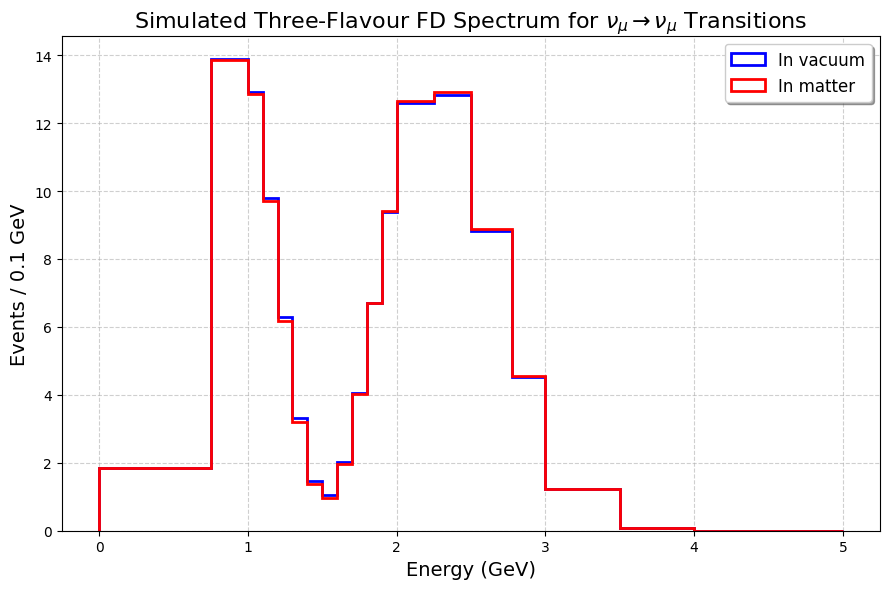

In [8]:
#fractions = np.linspace(-1,1,3) # -1*sigma, 0*sigma, 1*sigma
fractions1 = [0]

c_3f_1, err_3f_1, fc_3f_1, p_3f_1 = osc_prob_3nu('neutrino', 'vacuum', length_nd, 'Pme', fractions1)
c_3f_2, err_3f_2, fc_3f_2, p_3f_2 = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pme', fractions1)

c_3f_3, err_3f_3, fc_3f_3, p_3f_3 = osc_prob_3nu('neutrino', 'matter', length_nd, 'Pme', fractions1)
c_3f_4, err_3f_4, fc_3f_4, p_3f_4 = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pme', fractions1)

c_3f_1_, err_3f_1_, fc_3f_1_, p_3f_1_ = osc_prob_3nu('antineutrino', 'vacuum', length_nd, 'Pme', fractions1)
c_3f_2_, err_3f_2_, fc_3f_2_, p_3f_2_ = osc_prob_3nu('antineutrino', 'vacuum', length_fd, 'Pme', fractions1)

c_3f_3_, err_3f_3_, fc_3f_3_, p_3f_3_ = osc_prob_3nu('antineutrino', 'matter', length_nd, 'Pme', fractions1)
c_3f_4_, err_3f_4_, fc_3f_4_, p_3f_4_ = osc_prob_3nu('antineutrino', 'matter', length_fd, 'Pme', fractions1)

cmm, errmm,fcmm, pmm = osc_prob_3nu('neutrino', 'vacuum', length_fd, 'Pmm', fractions1)
cmm2, errmm2,fcmm2, pmm2 = osc_prob_3nu('neutrino', 'matter', length_fd, 'Pmm', fractions1)


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=cmm, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=cmm2, histtype='step', label=r'In matter', linewidth=2, color='red')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _\mu$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

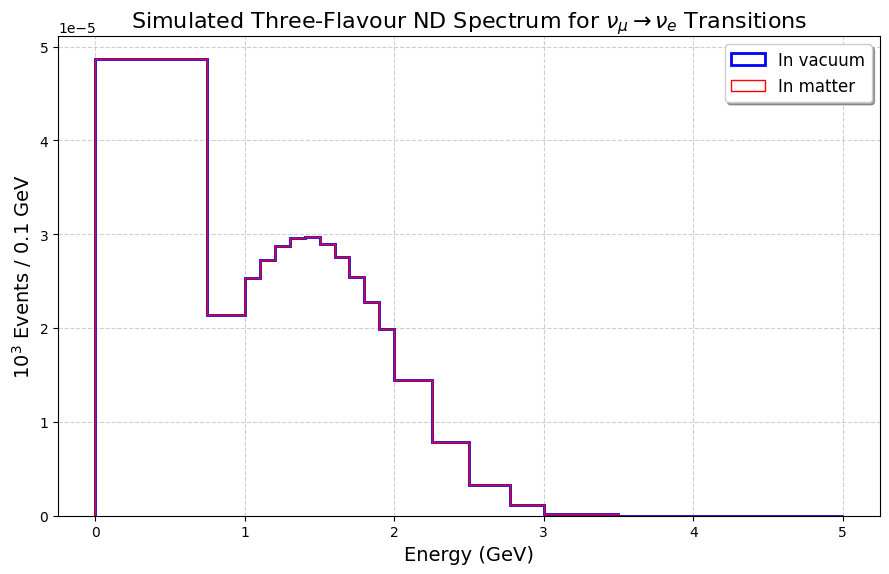

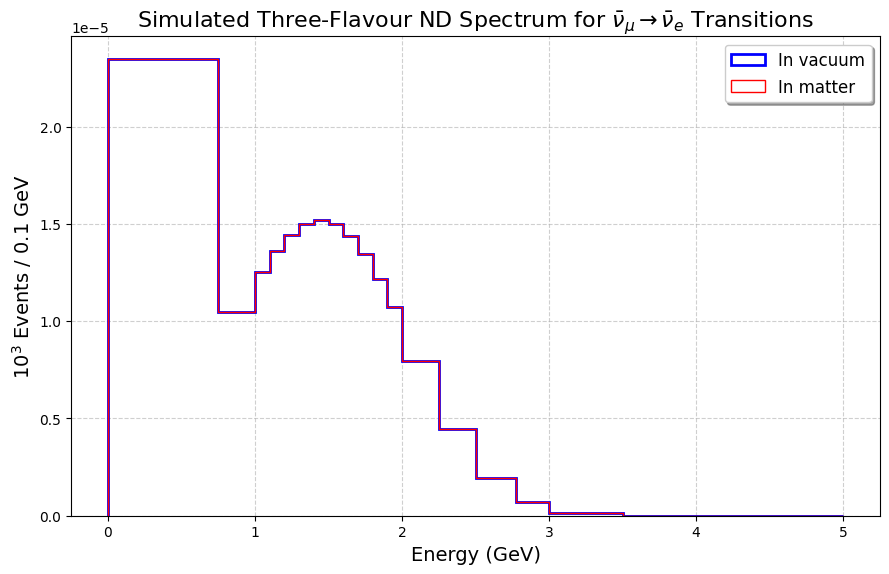

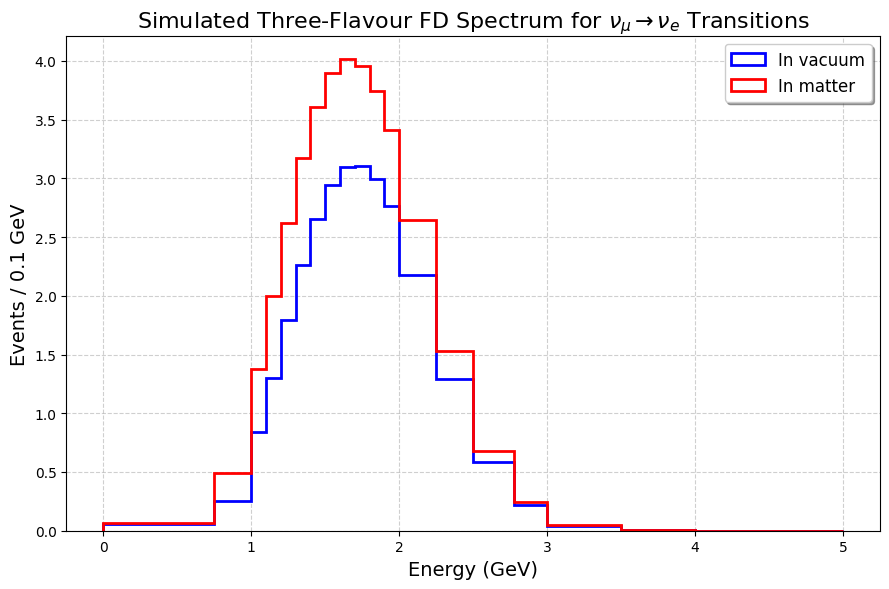

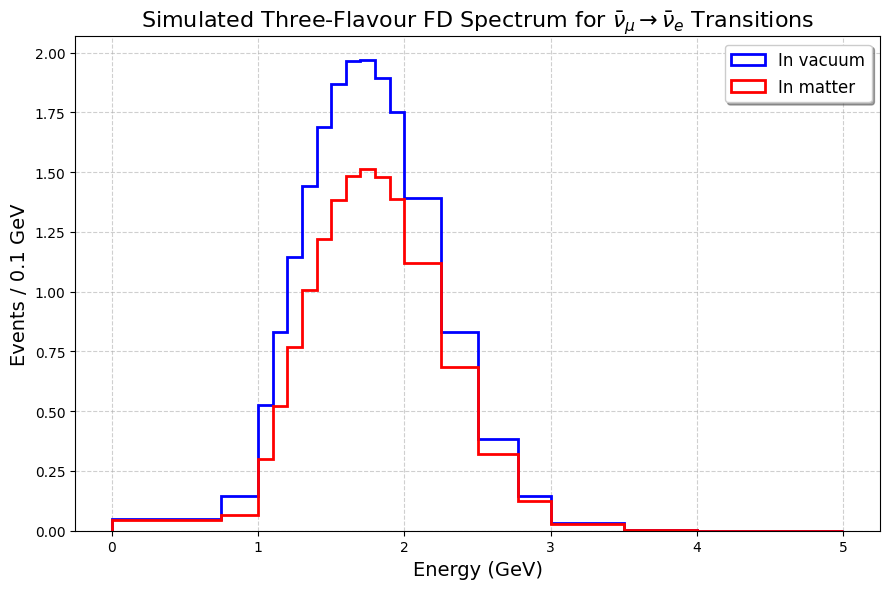

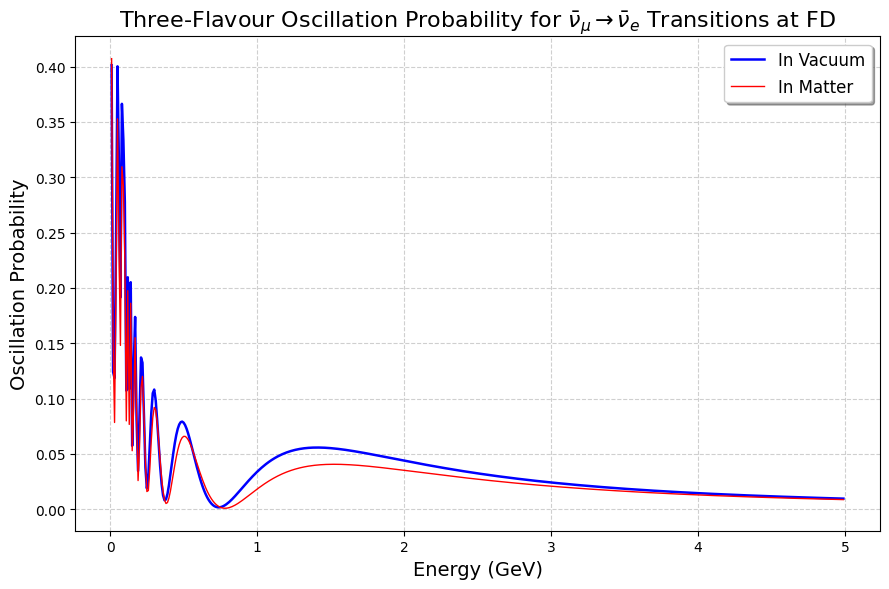

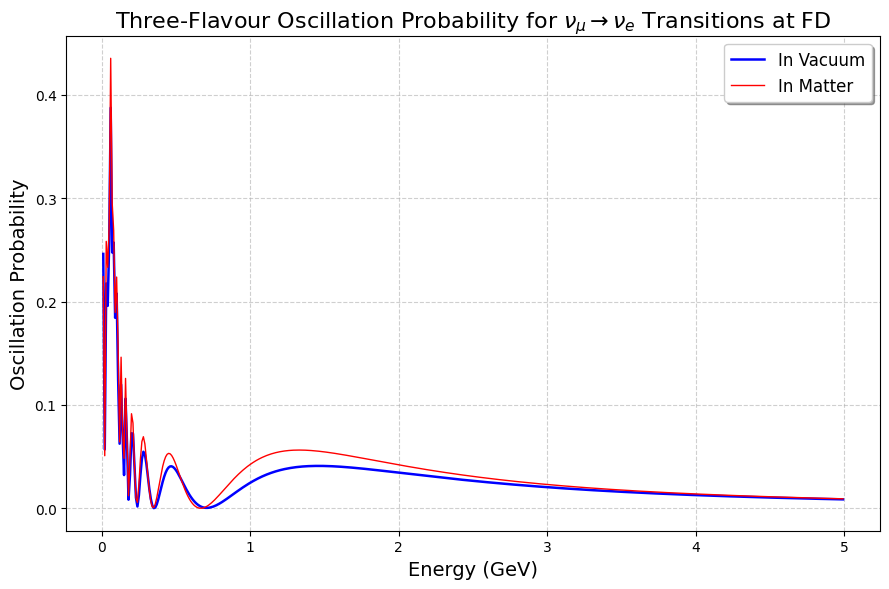

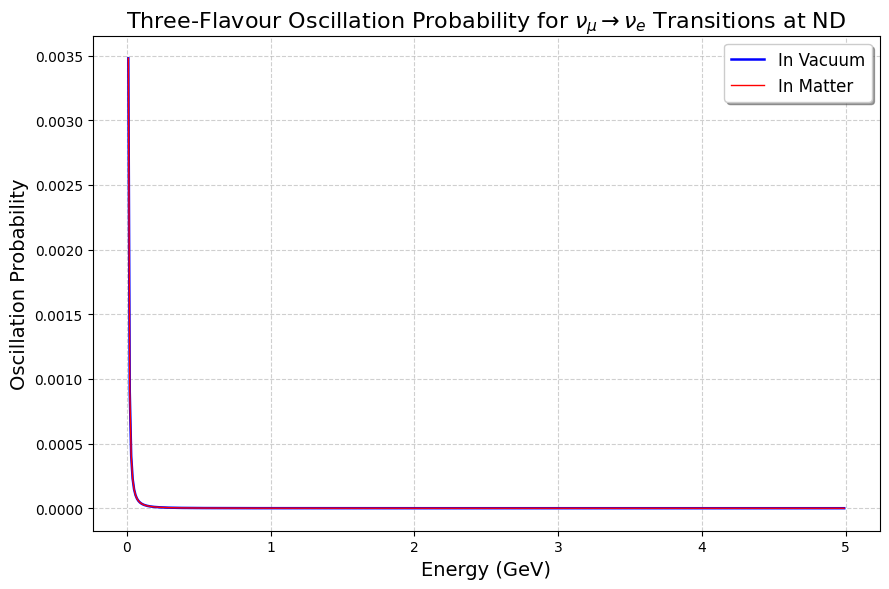

In [9]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_1, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_3, histtype='step', label=r'In matter', linewidth=1, color='red')
title = r'Simulated Three-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_1_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_3_, histtype='step', label=r'In matter', linewidth=1, color='red')
title = r'Simulated Three-Flavour ND Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_2, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_4, histtype='step', label=r'In matter', linewidth=2, color='red')
title = r'Simulated Three-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_2_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c_3f_4_, histtype='step', label=r'In matter', linewidth=2, color='red')
title = r'Simulated Three-Flavour FD Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Osc prob
plt.figure(figsize=(9,6))
plt.plot(x, p_3f_2_, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p_3f_4_, label=r'In Matter', linewidth=1, color='r')
title = r'Three-Flavour Oscillation Probability for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.ylim(0,1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p_3f_2, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p_3f_4, label=r'In Matter', linewidth=1, color='r')
title = r'Three-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p_3f_1, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p_3f_3, label=r'In Matter', linewidth=1, color='r')
title = r'Three-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

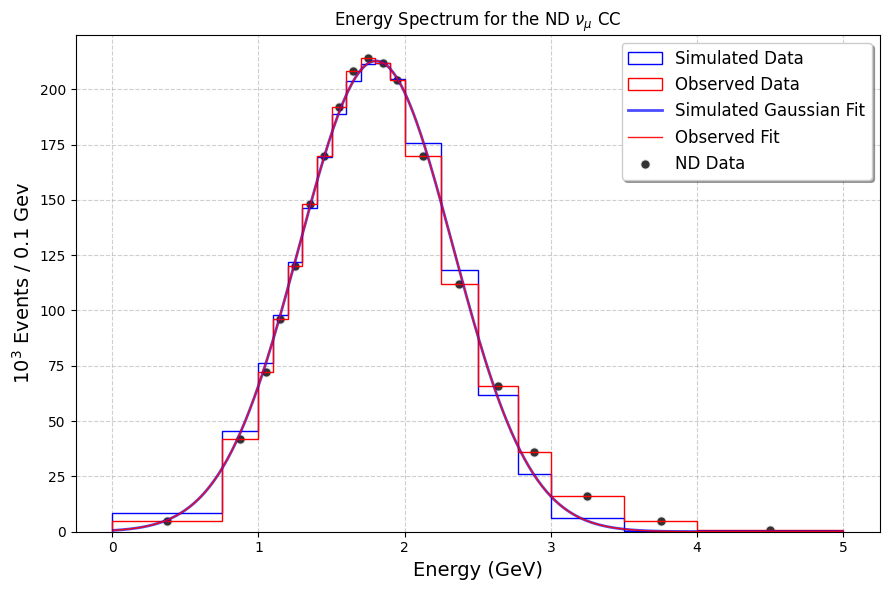

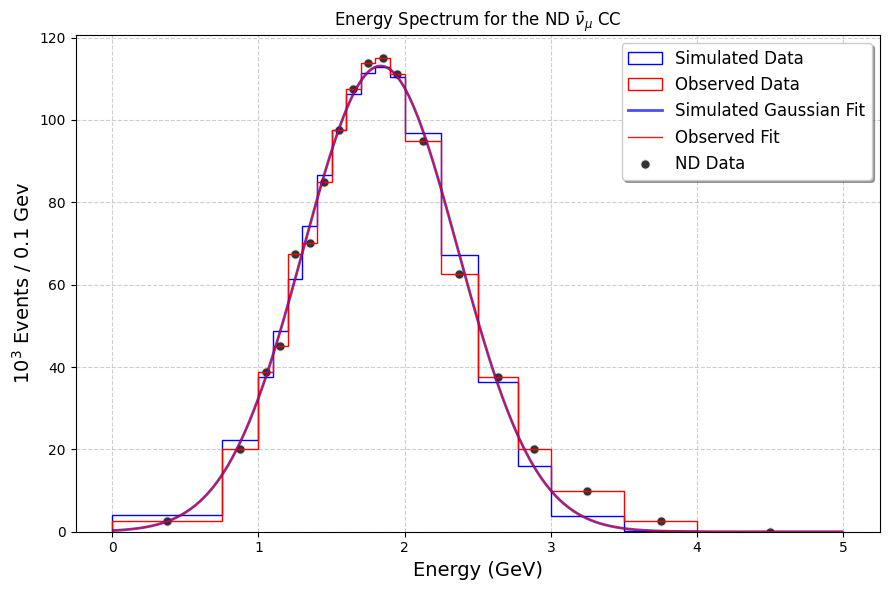

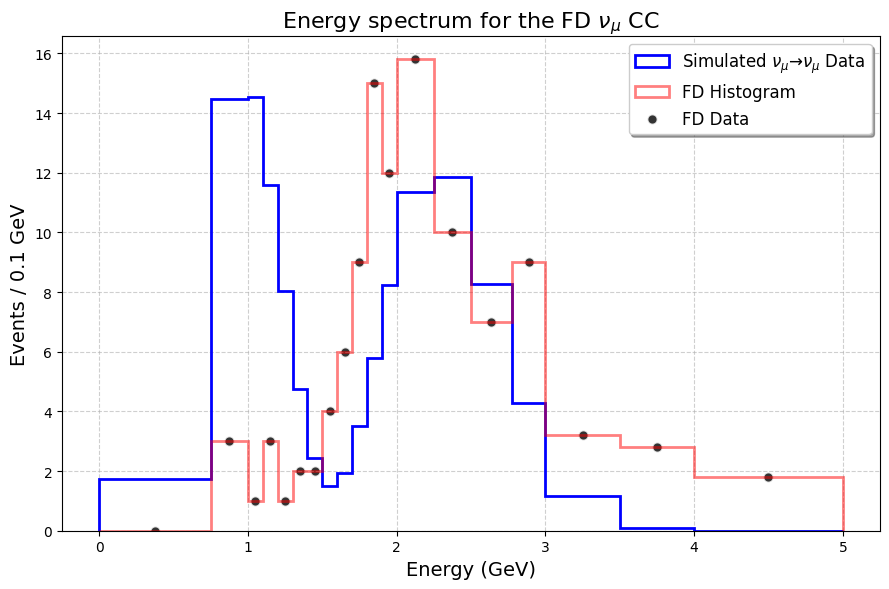

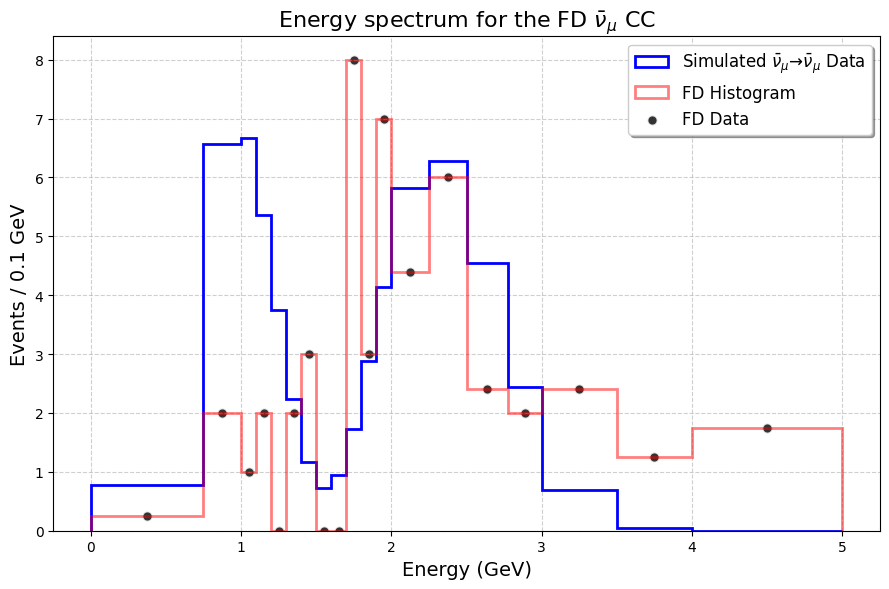

In [10]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c1, histtype='step', label='Simulated Data', linewidth=1, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts_nd, histtype='step', label='Observed Data', linewidth=1, color='red')
plt.plot(x,fit1, label='Simulated Gaussian Fit', linewidth=2, color='b', alpha=0.7)
plt.plot(x, gaus(x, *popt_nd), label='Observed Fit', linewidth=1, color='r', alpha=0.9)
plt.scatter(bin_centers, counts_nd, color='black', label='ND Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.title(r'Energy Spectrum for the ND $\nu _\mu$ CC')
plt.ylabel(r'$10^3$ Events / 0.1 Gev', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c1_, histtype='step', label='Simulated Data', linewidth=1, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=anti_counts_nd, histtype='step', label='Observed Data', linewidth=1, color='red')
plt.plot(x,fit1_, label='Simulated Gaussian Fit', linewidth=2, color='b', alpha=0.7)
plt.plot(x, gaus(x, *popt_anti_nd), label='Observed Fit', linewidth=1, color='r', alpha=0.9)
plt.scatter(bin_centers, anti_counts_nd, color='black', label='ND Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.title(r'Energy Spectrum for the ND $\bar{\nu} _\mu$ CC')
plt.ylabel(r'$10^3$ Events / 0.1 Gev', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c2, histtype='step', label=r'Simulated $\nu _\mu \to \nu _\mu$ Data', linewidth=2, color='b')
plt.hist(bin_edges[:-1], bin_edges,weights=counts_fd, density=False, alpha=0.5, histtype='step', color='r', label='FD Histogram', linewidth=2)
plt.scatter(bin_centers, counts_fd, color='black', label='FD Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.title(r'Energy spectrum for the FD $\nu _\mu$ CC', fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c2_, histtype='step', label=r'Simulated $\bar{\nu} _\mu \to \bar{\nu} _\mu$ Data', linewidth=2, color='b')
plt.hist(bin_edges[:-1], bin_edges,weights=anti_counts_fd, density=False, alpha=0.5, histtype='step', color='r', label='FD Histogram', linewidth=2)
plt.scatter(bin_centers, anti_counts_fd, color='black', label='FD Data' ,edgecolor='white', s=50, alpha=0.8, marker='o', linewidth=1.2 )
plt.title(r'Energy spectrum for the FD $\bar{\nu} _\mu$ CC', fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

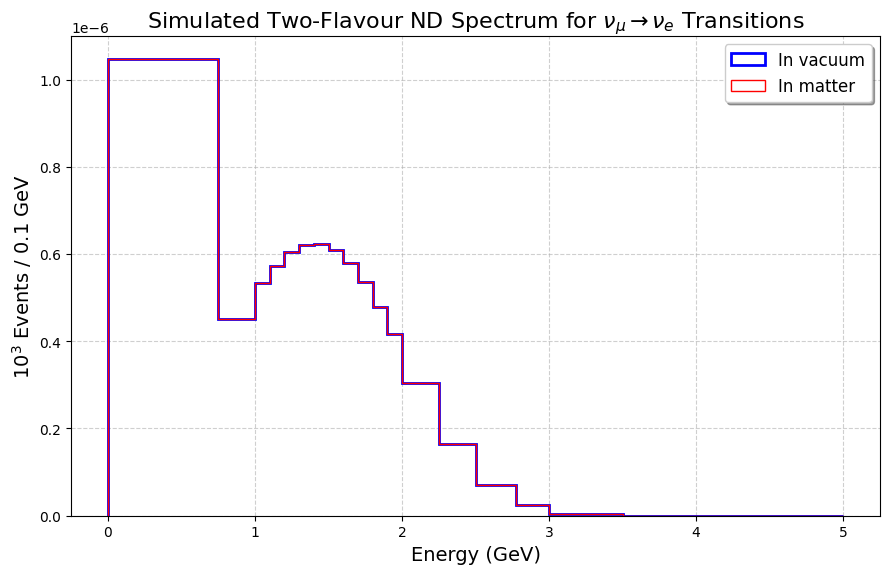

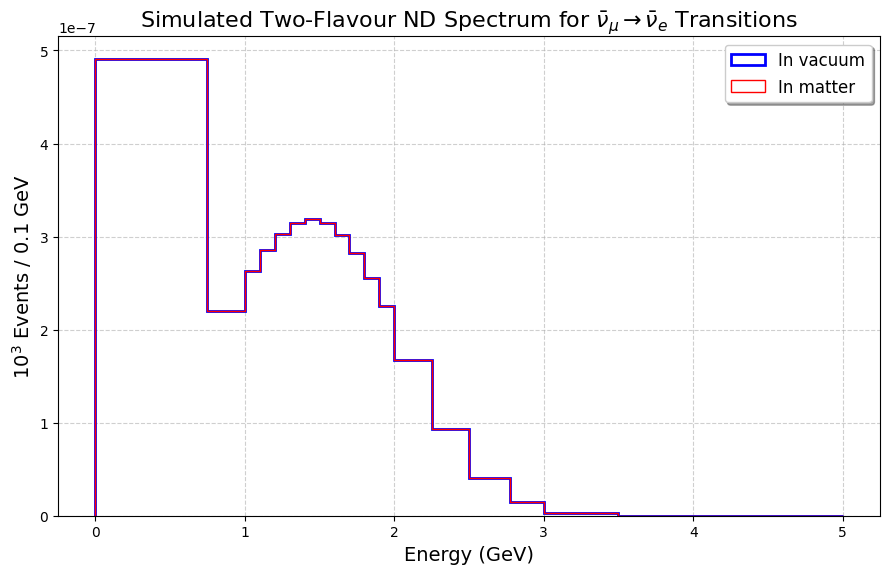

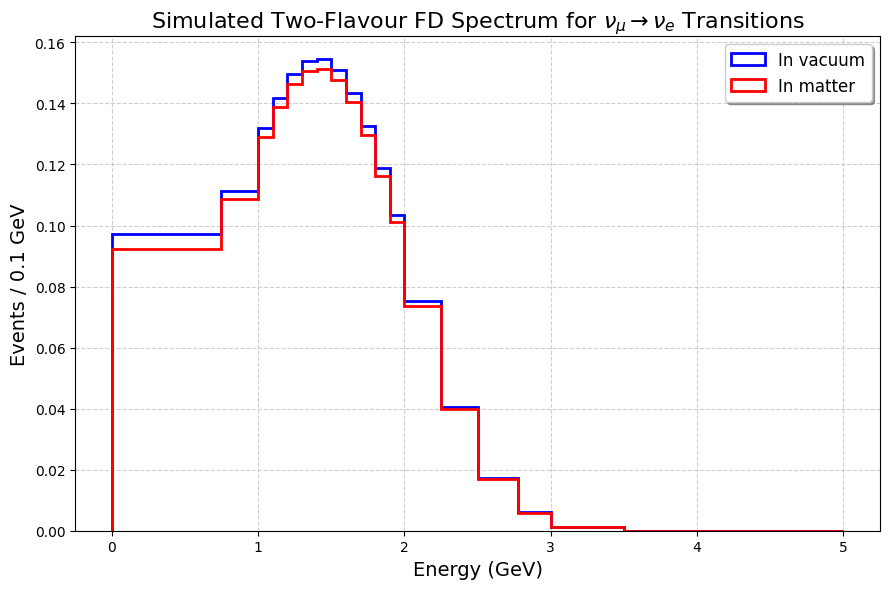

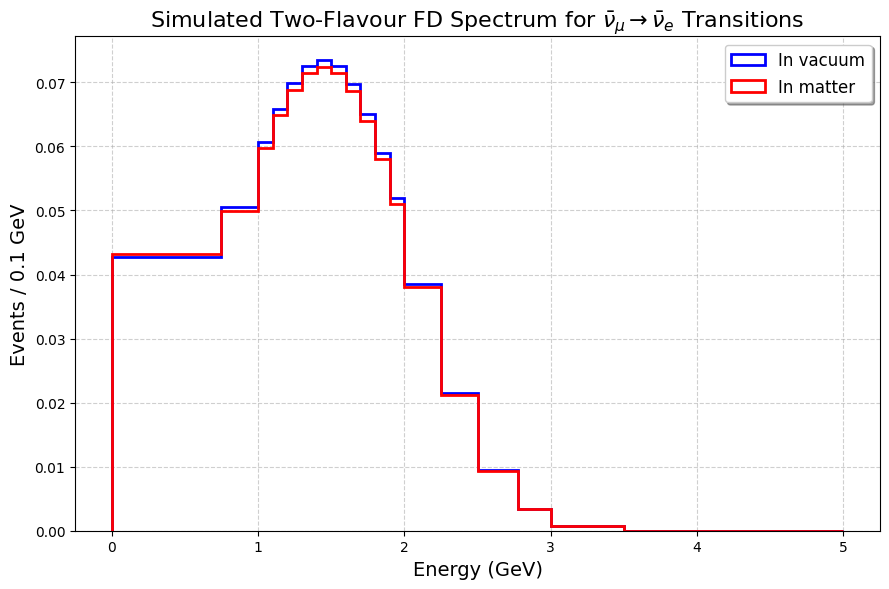

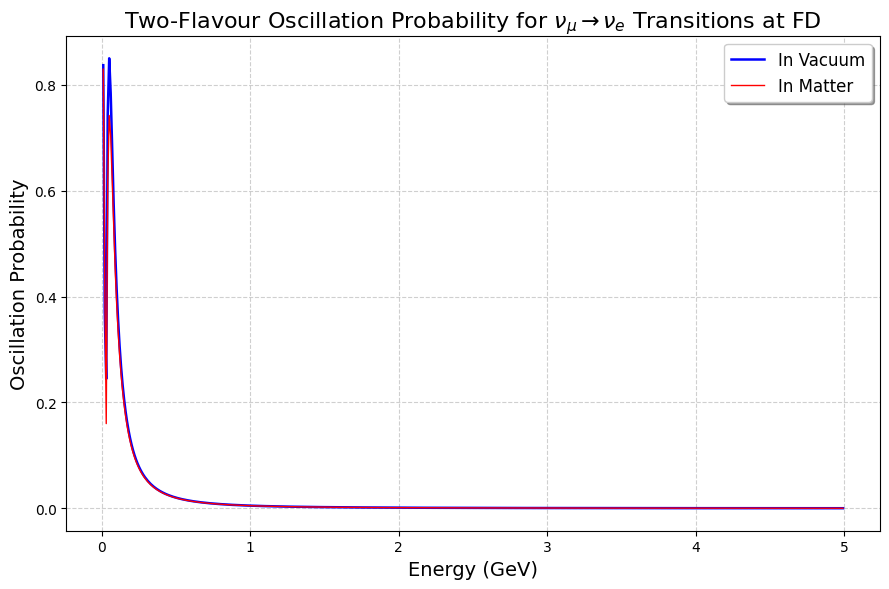

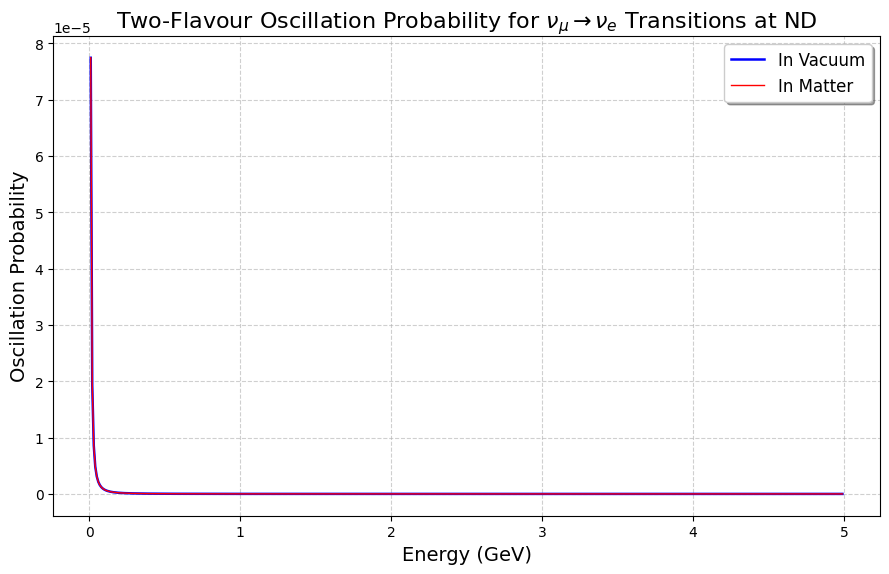

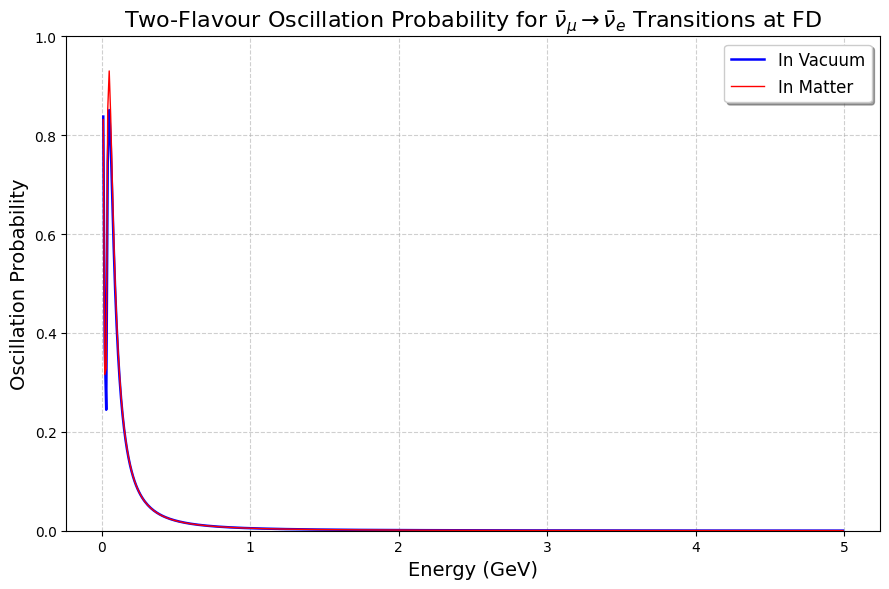

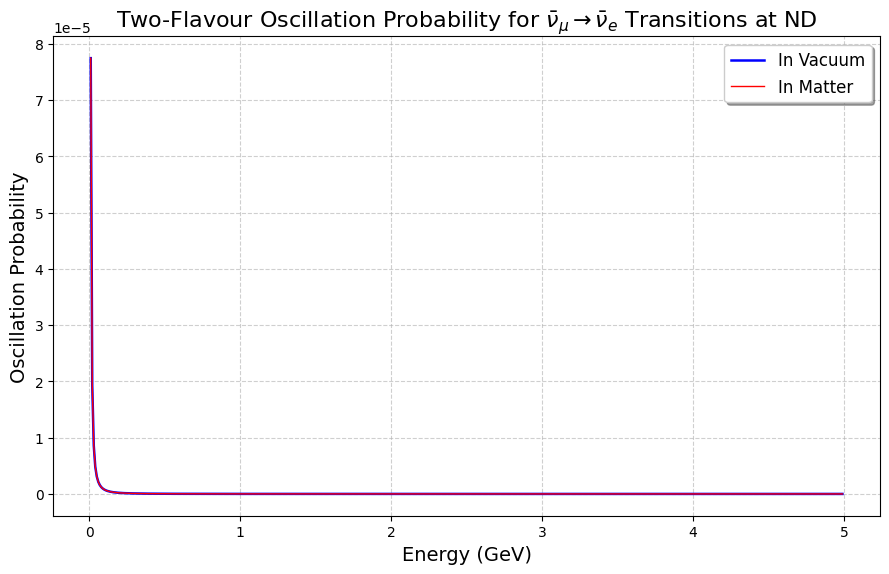

In [11]:
plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c5, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c7, histtype='step', label=r'In matter', linewidth=1, color='red')
title = r'Simulated Two-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c5_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c7_, histtype='step', label=r'In matter', linewidth=1, color='red')
title = r'Simulated Two-Flavour ND Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c6, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c8, histtype='step', label=r'In matter', linewidth=2, color='red')
title = r'Simulated Two-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c6_, histtype='step', label=r'In vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c8_, histtype='step', label=r'In matter', linewidth=2, color='red')
title = r'Simulated Two-Flavour FD Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel('Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p6, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p8, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p5, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p7, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p6_, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p8_, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.ylim(0,1)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p5_, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p7_, label=r'In Matter', linewidth=1, color='r')
title = r'Two-Flavour Oscillation Probability for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)

plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()